#### Dataset used - https://www.kaggle.com/c/fake-news/data

### Dataset Description

train.csv: A full training dataset with the following attributes:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article; could be incomplete
* label: a label that marks the article as potentially unreliable
  * 1: unreliable
  * 0: reliable

test.csv: A testing training dataset with all the same attributes at train.csv without the label.

submit.csv: A sample submission that you can use to submit your prediction results

In [1]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re #Regular expressions 
import nltk #Natural Language Toolkit
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from sklearn import metrics
import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mouad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data exploring: importing the data and visualizating it

In [2]:
# Loading the train dataset
train_df = pd.read_csv('train.csv')

In [3]:
#Visualization of train dataset
train_df.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [4]:
train_df.shape

(20800, 5)

### Data Cleaning : Removing Stop Words, Unnecessary Characters

In [5]:
# Checking for missing values
train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
# replacing the null values with empty string
train_df = train_df.fillna('')
train_df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [7]:
train_df.duplicated(subset=["text"]).value_counts()

False    20387
True       413
dtype: int64

In [8]:
duplicated_val = train_df[train_df.duplicated(subset=["text"])]
duplicated_val.head()

,id,title,author,text,label
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1
480,480,Watch: Muslim ‘Palestinians’ Declare “We follo...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1
573,573,Le top des recherches Google passe en top des ...,,,1


In [9]:
# drop duplicated data
train_df = train_df.drop_duplicates(subset={"text"}, keep='first', inplace=False)
train_df.shape

(20387, 5)

In [10]:
# We will add a new column contaning all text fields such as Title, Author & text description to train our model 
train_df['text_fileds_merged'] = train_df['author']+' '+train_df['title']+' '+train_df['text']
print(train_df['text_fileds_merged'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799    David Swanson What Keeps the F-35 Alive   Davi...
Name: text_fileds_merged, Length: 20387, dtype: object


In [11]:
train_df.head(10)

,id,title,author,text,label,text_fileds_merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,Daniel Nussbaum Jackie Mason: Hollywood Would ...
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,,Ever wonder how Britain’s most iconic pop pian...,1,Life: Life Of Luxury: Elton John’s 6 Favorite...
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,Alissa J. Rubin Benoît Hamon Wins French Socia...
8,8,Excerpts From a Draft Script for Donald Trump’...,,Donald J. Trump is scheduled to make a highly ...,0,Excerpts From a Draft Script for Donald Trump...
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,Megan Twohey and Scott Shane A Back-Channel Pl...


 ### Data pretraining:

In [13]:
port_stem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content
train_df['text_fileds_merged'] = train_df['text_fileds_merged'].apply(stemming)
print(train_df['text_fileds_merged'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2        consortiumnew com truth might get fire truth m...
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799    david swanson keep f aliv david swanson author...
Name: text_fileds_merged, Length: 20387, dtype: object


In [14]:
# separating the data & label so that we can access them after that
X = train_df['text_fileds_merged'].values
Y = train_df['label'].values

In [15]:
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet hous dem aid even see comey letter jason chaffetz tweet darrel lucu octob subscrib jason chaffetz stump american fork utah imag courtesi michael jolley avail creativ common licens apolog keith olbermann doubt worst person world week fbi director jame comey accord hous democrat aid look like also know second worst person well turn comey sent infam letter announc fbi look email may relat hillari clinton email server rank democrat relev committe hear comey found via tweet one republican committe chairmen know comey notifi republican chairmen democrat rank member hous intellig judiciari oversight committe agenc review email recent discov order see contain classifi inform long letter went oversight committe chairman jason chaffetz set polit world ablaz tweet fbi dir inform fbi learn exist email appear pertin investig case reopen jason chaffetz jasoninthehous octob cours know case comey actual say review email light unrel 

In [16]:
print(Y)

[1 0 1 ... 0 1 1]


In [17]:
#Converting textual data to numerical data, for that we will use TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
print(X)

  (0, 109690)	0.0491220253912036
  (0, 109635)	0.018952742575219117
  (0, 108681)	0.044083912142606166
  (0, 108677)	0.09486507454690839
  (0, 108634)	0.03756743463804837
  (0, 108597)	0.011273089240010392
  (0, 107946)	0.017076223813162237
  (0, 107129)	0.01704915669722183
  (0, 107038)	0.012492195936709926
  (0, 106952)	0.029131758167844368
  (0, 106873)	0.012798532836947893
  (0, 106673)	0.011735537685732406
  (0, 105824)	0.02574445249569315
  (0, 105788)	0.0312665233117507
  (0, 104778)	0.021553150420489362
  (0, 103363)	0.0653184277731247
  (0, 102677)	0.033086333030342786
  (0, 102426)	0.016351540597230468
  (0, 101658)	0.038017239208739305
  (0, 101018)	0.011047878589557655
  (0, 101008)	0.04306102530076629
  (0, 100955)	0.1359882808979317
  (0, 100807)	0.07101597642799454
  (0, 99519)	0.03948456472502695
  (0, 98952)	0.02705807858698606
  :	:
  (20386, 7464)	0.010574549305012596
  (20386, 7137)	0.028042563254444423
  (20386, 6842)	0.03947740593156757
  (20386, 6804)	0.025267514

In [ ]:
#confusion matrix
def plot_confusion_matrix(y_actual, y_pred):
    classes = ['Fake News', 'Real News']
    tick_marks = np.arange(len(classes))
    accuracy = accuracy_score(y_actual, y_pred)
    print("Accuracy score:", "{:2.3}".format(accuracy))
    conf_matrix = confusion_matrix(y_actual, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    plt.tight_layout()
    plt.xticks(tick_marks , classes, rotation=0)
    plt.yticks(tick_marks , classes)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

 ### Data training : Modeling & Model Evaluation

In [ ]:
#Splitting the dataset to training & test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify=Y, random_state=2)

##### Training the Model: Logistic Regression


In [19]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [21]:
# Accuracy Score on Training Data
X_train_prediction_LR = model.predict(X_train)
training_data_accuracy_LR = accuracy_score(X_train_prediction_LR, Y_train)
print('Accuracy score on the training data: ',training_data_accuracy_LR)

Accuracy score on the training data:  0.9787666433076384


In [22]:
# Accuracy Score on Test Data
X_test_prediction_LR = model.predict(X_test)
test_data_accuracy_LR = accuracy_score(X_test_prediction_LR, Y_test)
print('Accuracy score on the test data: ',test_data_accuracy_LR)

Accuracy score on the test data:  0.9530815759359162


Accuracy score: 0.953


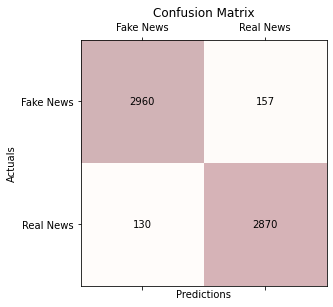

In [23]:
# plot confusion matrix on test
plot_confusion_matrix(Y_test, X_test_prediction_LR)

In [49]:
print("Recall : %.2f"%(metrics.recall_score(Y_test, X_test_prediction_LR)*100))

Recall : 95.67


In [50]:
print("Precision : %.2f"%(metrics.precision_score(Y_test, X_test_prediction_LR)*100))

Precision : 94.81


In [24]:
# Classification report for test data
classification_report(Y_test, X_test_prediction_LR)

'              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.95      3117\n           1       0.95      0.96      0.95      3000\n\n    accuracy                           0.95      6117\n   macro avg       0.95      0.95      0.95      6117\nweighted avg       0.95      0.95      0.95      6117\n'

##### Training the Model: DecisionTree

In [25]:
#Training the Model: DecisionTree
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,Y_train)

In [26]:
# Accuracy Score on Training Data
X_train_prediction_DT = clf.predict(X_train)
training_data_accuracy_DT = accuracy_score(X_train_prediction_DT, Y_train)
print('Accuracy score on the training data: ',training_data_accuracy_DT)

Accuracy score on the training data:  1.0


In [27]:
# Accuracy Score on Test Data
X_test_prediction_DT = clf.predict(X_test)
test_data_accuracy_DT = accuracy_score(X_test_prediction_DT, Y_test)
print('Accuracy score on the test data: ',test_data_accuracy_DT)

Accuracy score on the test data:  0.9583128984796468


Accuracy score: 0.958


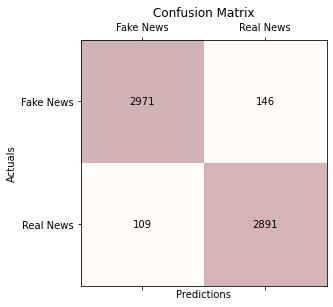

In [28]:
# plot confusion matrix on test
plot_confusion_matrix(Y_test, X_test_prediction_DT)

In [51]:
print("Recall : %.2f"%(metrics.recall_score(Y_test, X_test_prediction_DT)*100))

Recall : 96.37


In [52]:
print("Precision : %.2f"%(metrics.precision_score(Y_test, X_test_prediction_DT)*100))

Precision : 95.19


In [29]:
# Classification report for test data
classification_report(Y_test, X_test_prediction_DT)

'              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.96      3117\n           1       0.95      0.96      0.96      3000\n\n    accuracy                           0.96      6117\n   macro avg       0.96      0.96      0.96      6117\nweighted avg       0.96      0.96      0.96      6117\n'

##### Training the Model: RandomForest

In [31]:
#Training the Model: RandomForest
RF=RandomForestClassifier(n_estimators=100)
RF.fit(X_train,Y_train)

RandomForestClassifier()

In [32]:
# Accuracy Score on Training Data
X_train_prediction_RF = RF.predict(X_train)
training_data_accuracy_RF = accuracy_score(X_train_prediction_RF, Y_train)
print('Accuracy score on the training data: ',training_data_accuracy_RF)

Accuracy score on the training data:  1.0


In [33]:
# Accuracy Score on Test Data
X_test_prediction_RF = RF.predict(X_test)
test_data_accuracy_RF = accuracy_score(X_test_prediction_RF, Y_test)
print('Accuracy score on the test data: ',test_data_accuracy_RF)

Accuracy score on the test data:  0.9337910740559098


Accuracy score: 0.934


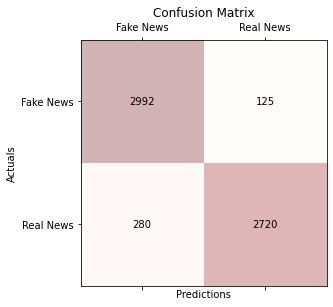

In [34]:
# plot confusion matrix on test
plot_confusion_matrix(Y_test, X_test_prediction_RF)

In [53]:
print("Recall : %.2f"%(metrics.recall_score(Y_test, X_test_prediction_RF)*100))

Recall : 90.67


In [54]:
print("Precision : %.2f"%(metrics.precision_score(Y_test, X_test_prediction_RF)*100))

Precision : 95.61


In [35]:
# Classification report for test data
classification_report(Y_test, X_test_prediction_RF)

'              precision    recall  f1-score   support\n\n           0       0.91      0.96      0.94      3117\n           1       0.96      0.91      0.93      3000\n\n    accuracy                           0.93      6117\n   macro avg       0.94      0.93      0.93      6117\nweighted avg       0.93      0.93      0.93      6117\n'

##### Accuracy comparison: 

DecisionTree is the more accurate


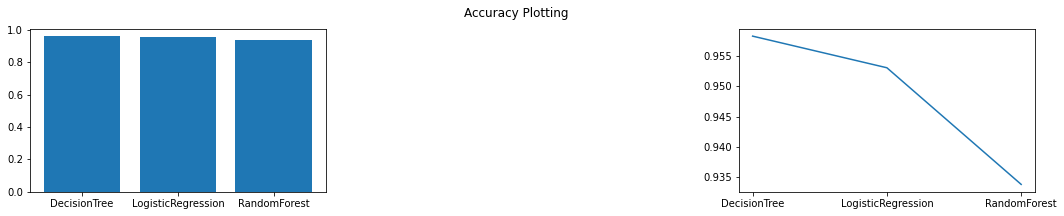

In [64]:
max_accuracy = max(test_data_accuracy_DT,test_data_accuracy_RF,test_data_accuracy_LR)
if test_data_accuracy_DT == max_accuracy : 
    print("DecisionTree is the more accurate")
elif test_data_accuracy == max_accuracy:
    print("LogisticRegression is the more accurate")
else:
    print("RandomForest is the more accurate")
names = ['DecisionTree', 'LogisticRegression', 'RandomForest']
values = [test_data_accuracy_DT, test_data_accuracy_LR, test_data_accuracy_RF]
plt.figure(figsize=(18, 3))
plt.subplot(131)
plt.bar(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Accuracy Plotting')
plt.show()

##### Recall comparison: 

DecisionTree has the best recall


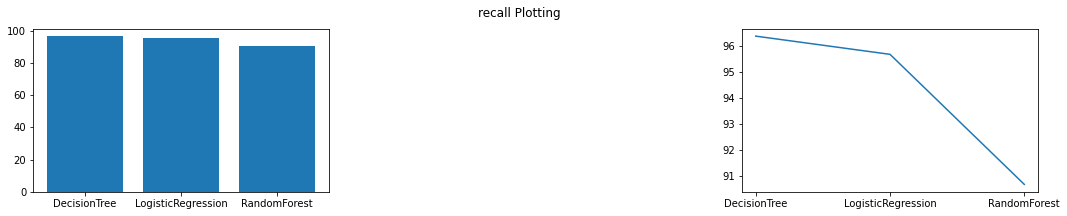

In [59]:
test_data_recall_DT= metrics.recall_score(Y_test, X_test_prediction_DT)*100
test_data_recall_RF= metrics.recall_score(Y_test, X_test_prediction_RF)*100
test_data_recall_LR=metrics.recall_score(Y_test, X_test_prediction_LR)*100
max_recall = max(test_data_recall_DT,test_data_recall_RF,test_data_recall_LR)
if test_data_recall_DT == max_recall : 
    print("DecisionTree has the best recall")
elif test_data_recall_LR == max_recall:
    print("LogisticRegression has the best recall")
else:
    print("RandomForest has the best recall")
names = ['DecisionTree', 'LogisticRegression', 'RandomForest']
values = [test_data_recall_DT, test_data_recall_LR, test_data_recall_RF]
plt.figure(figsize=(18, 3))
plt.subplot(131)
plt.bar(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('recall Plotting')
plt.show()

##### Precision comparison: 

RandomForest has the best precision


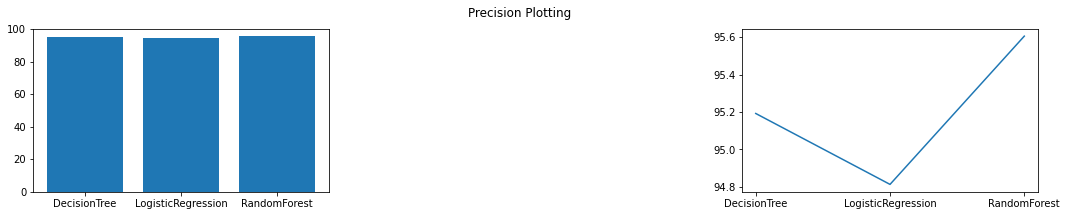

In [60]:
test_data_precision_DT= metrics.precision_score(Y_test, X_test_prediction_DT)*100
test_data_precision_RF= metrics.precision_score(Y_test, X_test_prediction_RF)*100
test_data_precision_LR=metrics.precision_score(Y_test, X_test_prediction_LR)*100
max_precision = max(test_data_precision_DT,test_data_precision_RF,test_data_precision_LR)
if test_data_precision_DT == max_precision : 
    print("DecisionTree has the best precision")
elif test_data_precision_LR == max_precision:
    print("LogisticRegression has the best precision")
else:
    print("RandomForest has the best precision")
names = ['DecisionTree', 'LogisticRegression', 'RandomForest']
values = [test_data_precision_DT, test_data_precision_LR, test_data_precision_RF]
plt.figure(figsize=(18, 3))
plt.subplot(131)
plt.bar(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Precision Plotting')
plt.show()

### Testing the Predictive System

In [37]:
X_new = X_test[100]

predictionLR = model.predict(X_new)
predictionDT = clf.predict(X_new)
predictionRF = RF.predict(X_new)
if (predictionLR[0] == 0):
    print('The news are Real and reliable following LogisticRegression')
if(predictionLR[0] == 1):
    print('The news are Fake and Unreliable following LogisticRegression')
if (predictionDT[0] == 0):
    print('The news are Real and reliable following DecisionTree')
if (predictionDT[0] == 1):
    print('The news are Fake and Unreliable following DecisionTree')
if (predictionRF[0] == 0):
    print('The news are Real and reliable following RandomForest')
if (predictionRF[0] == 1):
    print('The news are Fake and Unreliable following RandomForest')

The news are Real and reliable following LogisticRegression
The news are Real and reliable following DecisionTree
The news are Real and reliable following RandomForest


In [38]:
train_df[99:100]

,id,title,author,text,label,text_fileds_merged
99,99,"M.I.T., N.Y.U. and Yale Are Sued Over Retireme...",Tara Siegel Bernard,Three prominent universities were sued on Tues...,0,tara siegel bernard n u yale su retir plan fee...
